# Import Library

- gdown: digunakan untuk mengunduh file dari Google Drive menggunakan ID file.
- pandas, numpy: pustaka utama untuk manipulasi data dan perhitungan numerik.
- matplotlib.pyplot, seaborn: pustaka visualisasi untuk eksplorasi dan analisis data.
- datetime: digunakan untuk menangani tipe data waktu.
- sklearn: menyediakan alat bantu preprocessing dan metrik evaluasi model ML.
- tensorflow.keras: digunakan untuk membangun dan melatih model deep learning berbasis LSTM.

In [ ]:
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load Dataset

Dataset diunduh dari Google Drive menggunakan gdown dan disimpan sebagai dataset.csv.
Kemudian, dataset dibaca ke dalam DataFrame menggunakan pd.read_csv() untuk proses selanjutnya.

In [ ]:
#membaca dataset https://drive.google.com/file/d/1h7vtc3wEve5Lx9-pVfXEkij1cU-kfYQi/view?usp=drive_link
file_id = "1h7vtc3wEve5Lx9-pVfXEkij1cU-kfYQi"
url = f"https://drive.google.com/uc?id={file_id}"
output = "dataset.csv"

gdown.download(url, output, quiet=False)

df = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1h7vtc3wEve5Lx9-pVfXEkij1cU-kfYQi
To: /content/dataset.csv
100%|██████████| 80.4k/80.4k [00:00<00:00, 49.9MB/s]


In [ ]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,04/24/2025,106.43,103.47,106.54,103.11,217.19M,3.62%
1,04/23/2025,102.71,104.52,104.80,102.02,247.53M,3.86%
2,04/22/2025,98.89,98.78,99.81,97.28,241.00M,2.04%
3,04/21/2025,96.91,98.77,99.44,95.04,288.50M,-4.51%
4,04/17/2025,101.49,104.45,104.47,100.05,292.52M,-2.87%


# Preprocessing Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1256 non-null   object 
 1   Price     1256 non-null   float64
 2   Open      1256 non-null   float64
 3   High      1256 non-null   float64
 4   Low       1256 non-null   float64
 5   Vol.      1256 non-null   object 
 6   Change %  1256 non-null   object 
dtypes: float64(4), object(3)
memory usage: 68.8+ KB


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

untuk mengonversi kolom tanggal (Date) menjadi format datetime, sehingga lebih mudah diolah saat analisis waktu atau visualisasi.

In [ ]:
def parse_volume(vol):
    vol = vol.replace(',', '').strip()
    if 'B' in vol:
        return float(vol.replace('B', '')) * 1_000_000_000
    elif 'M' in vol:
        return float(vol.replace('M', '')) * 1_000_000
    else:
        return float(vol)  # fallback kalau tanpa simbol

df['Vol.'] = df['Vol.'].astype(str).apply(parse_volume)

# Bersihkan kolom 'Change %'
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

1. Membersihkan dan mengonversi kolom volume (Vol.):
- Menghapus koma (,) dan satuan volume seperti 'B' (billion) dan 'M' (million).
- Mengubah string menjadi nilai numerik dalam satuan standar.

2. Menghapus simbol persen (%) dari kolom Change % dan mengonversinya ke tipe data float.

In [ ]:
X_lr = df[['Open', 'High', 'Low', 'Vol.']]
y_lr = df['Price']

1. X_lr adalah variabel independen atau fitur yang digunakan untuk memprediksi harga saham. Fitur yang dipilih adalah:
- Open: harga pembukaan saham
- High: harga tertinggi dalam sehari
- Low: harga terendah dalam sehari
- Vol.: volume transaksi

2. y_lr adalah variabel target atau harga saham (Price) yang ingin diprediksi.

In [ ]:
# Normalisasi fitur
scaler_knn = MinMaxScaler()
X_knn_scaled = scaler_knn.fit_transform(X_lr)

# Exploratory Data Analysis

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1256 non-null   datetime64[ns]
 1   Price     1256 non-null   float64       
 2   Open      1256 non-null   float64       
 3   High      1256 non-null   float64       
 4   Low       1256 non-null   float64       
 5   Vol.      1256 non-null   float64       
 6   Change %  1256 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 68.8 KB


,Date,Price,Open,High,Low,Vol.,Change %
count,1256,1256.000000,1256.000000,1256.000000,1256.000000,1.256000e+03,1256.000000
mean,2022-10-23 00:12:36.687898112,45.598646,45.618065,46.479339,44.646385,4.312259e+08,0.269490
min,2020-04-27 00:00:00,7.070000,7.020000,7.220000,7.020000,9.788000e+07,-16.970000
25%,2021-07-25 06:00:00,15.005000,15.042500,15.312500,14.780000,2.964900e+08,-1.622500
50%,2022-10-20 12:00:00,23.730000,23.740000,24.270000,23.310000,4.096200e+08,0.315000
75%,2024-01-23 06:00:00,60.160000,60.112500,60.692500,59.287500,5.286450e+08,2.230000
max,2025-04-24 00:00:00,149.430000,153.030000,153.130000,147.820000,1.540000e+09,24.370000
std,NaN,42.266456,42.355580,43.118597,41.383801,1.813578e+08,3.343638


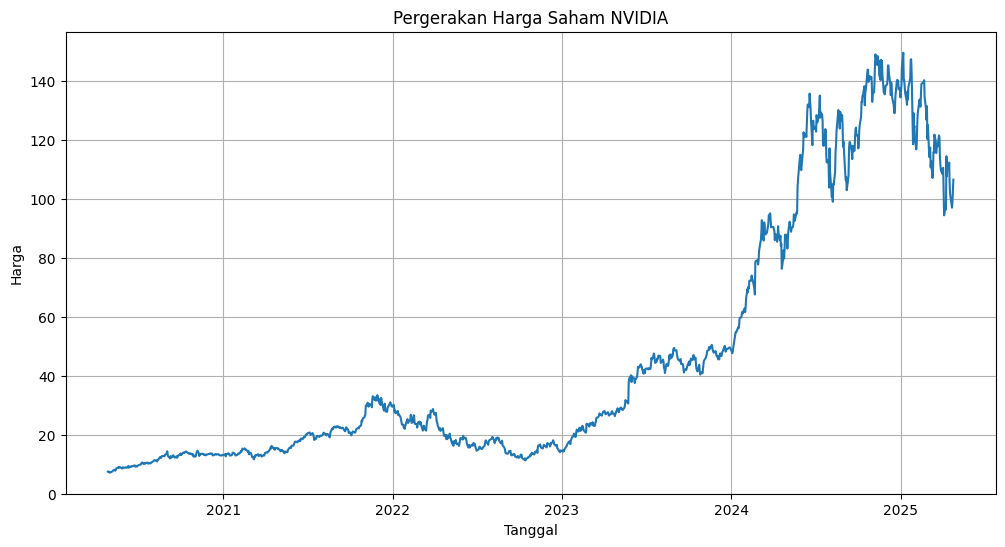

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Price'])
plt.title('Pergerakan Harga Saham NVIDIA')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.grid(True)
plt.show()

Visualisasi tren harga saham NVIDIA dari waktu ke waktu. Ini membantu mengamati pola musiman, lonjakan harga, atau tren jangka panjang.

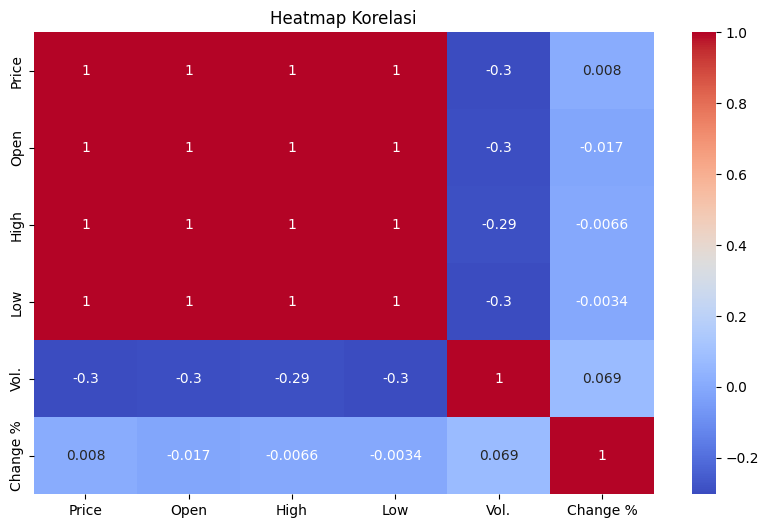

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi')
plt.show()

Heatmap korelasi antar fitur numerik untuk mengetahui hubungan antar variabel seperti Price, Open, High, Low, dan Vol. Korelasi tinggi dapat digunakan sebagai insight untuk pemodelan.

## Modeling (KNN)

In [ ]:
# Modeling KNN
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_knn_scaled, y_lr)
y_pred_knn = knn_model.predict(X_knn_scaled)

mae_knn = mean_absolute_error(y_lr, y_pred_knn)
rmse_knn = mean_squared_error(y_lr, y_pred_knn)
r2_knn = r2_score(y_lr, y_pred_knn)

print("\nKNN Regression Evaluation:")
print("MAE:", mae_knn)
print("RMSE:", rmse_knn)
print("R2 Score:", r2_knn)


KNN Regression Evaluation:
MAE: 0.6873136942675161
RMSE: 1.2151901369426752
R2 Score: 0.999319233037039


KNeighborsRegressor(n_neighbors=5): Model KNN dibuat dengan parameter n_neighbors=5, yang berarti model akan menggunakan 5 tetangga terdekat untuk membuat prediksi harga saham.

# Modeling (Linear Regression)

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X_lr, y_lr)
y_pred_lr = lr_model.predict(X_lr)

mae_lr = mean_absolute_error(y_lr, y_pred_lr)
rmse_lr = root_mean_squared_error(y_lr, y_pred_lr)
r2_lr = r2_score(y_lr, y_pred_lr)

print("Linear Regression Evaluation:")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R2 Score:", r2_lr)

Linear Regression Evaluation:
MAE: 0.39375531464936464
RMSE: 0.6989101754506425
R2 Score: 0.9997263490484886


- LinearRegression() membuat objek model regresi linear dari library scikit-learn.

- fit(X_lr, y_lr) melakukan pelatihan model dengan mempelajari hubungan antara fitur dan target berdasarkan data yang ada.

- predict(X_lr) digunakan untuk menghasilkan prediksi harga saham berdasarkan model yang sudah dilatih.

# Modeling: LSTM

In [ ]:
price_data = df[['Price']]
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(price_data)

- Kolom Price yang digunakan untuk pelatihan model LSTM.
- MinMaxScaler digunakan untuk menormalkan data harga agar berada dalam rentang 0–1, yang penting untuk mempercepat dan menstabilkan proses pelatihan neural network seperti LSTM.

Membuat Data Window Time Series

In [ ]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_lstm, y_lstm = create_dataset(price_scaled, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

In [ ]:
# Model LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


- Model menggunakan dua lapisan LSTM masing-masing dengan 50 unit: return_sequences=True artinya LSTM pertama mengembalikan seluruh urutan untuk layer LSTM kedua.
- Dense(1) digunakan untuk memprediksi satu nilai harga saham.
- Model dikompilasi dengan:
  - Loss function: mean_squared_error
  - Optimizer: adam untuk pelatihan yang efisien dan stabil.

In [ ]:
# Training
lstm_model.fit(X_lstm, y_lstm, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.0323
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 0.0011
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 9.0367e-04
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 9.0892e-04
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 8.2627e-04
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 8.8099e-04
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 7.4016e-04
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 8.1686e-04
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 6.8022e-04
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 6.4364e-04


Model dilatih selama 10 epoch dengan ukuran batch 32.

In [ ]:
# Prediction & Evaluation
y_pred_lstm = lstm_model.predict(X_lstm)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_lstm_inv = scaler.inverse_transform(y_lstm.reshape(-1, 1))

mae_lstm = mean_absolute_error(y_lstm_inv, y_pred_lstm_inv)
rmse_lstm = root_mean_squared_error(y_lstm_inv, y_pred_lstm_inv)
r2_lstm = r2_score(y_lstm_inv, y_pred_lstm_inv)

print("\nLSTM Model Evaluation:")
print("MAE:", mae_lstm)
print("RMSE:", rmse_lstm)
print("R2 Score:", r2_lstm)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

LSTM Model Evaluation:
MAE: 2.4101982121487544
RMSE: 4.126821935681614
R2 Score: 0.9893393471433133


Model memprediksi harga berdasarkan input time-series.

## Visualisasi

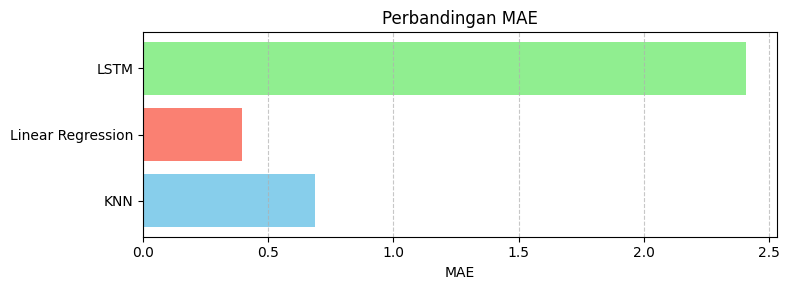

In [ ]:
#Visualisasi MAE
plt.figure(figsize=(8, 3))
models = ['KNN', 'Linear Regression', 'LSTM']
mae_values = [mae_knn, mae_lr, mae_lstm]

plt.barh(models, mae_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel('MAE')
plt.title('Perbandingan MAE')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Linear Regression memiliki MAE yang jauh lebih kecil dibanding KNN dan LSTM, artinya secara umum model ini membuat kesalahan prediksi yang lebih kecil rata-ratanya dibanding KNN dan LSTM.

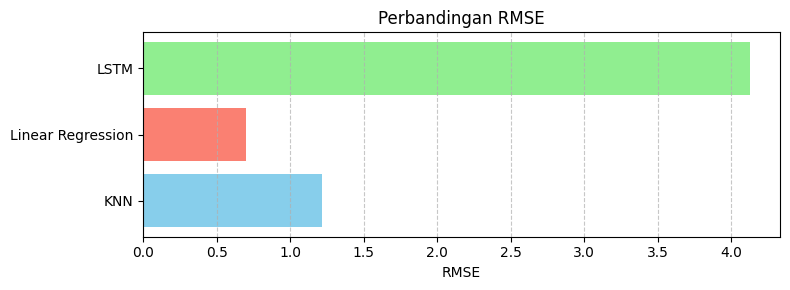

In [ ]:
#Visualisasi RMSE
plt.figure(figsize=(8, 3))
rmse_values = [rmse_knn, rmse_lr, rmse_lstm]

plt.barh(models, rmse_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel('RMSE')
plt.title('Perbandingan RMSE')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Linear Regression kembali unggul, dengan nilai RMSE yang jauh lebih kecil. Ini menunjukkan bahwa prediksi Linear Regression tidak hanya rata-rata lebih akurat (MAE), tapi juga lebih stabil terhadap outlier.

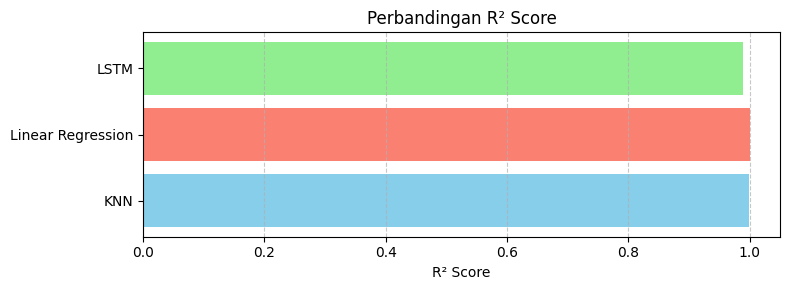

In [ ]:
#Visualisasi R2 Score
plt.figure(figsize=(8, 3))
r2_values = [r2_knn, r2_lr, r2_lstm]

plt.barh(models, r2_values, color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel('R² Score')
plt.title('Perbandingan R² Score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Ketiga model memiliki R² Score yang sangat tinggi, menunjukkan keduanya sangat mampu memodelkan hubungan dalam data. Namun Linear Regression sedikit lebih unggul dengan nilai hampir sempurna (0.9997).